#### Deep Neural Network 알고리즘을 Python의 Numpy를 기반으로 class와 def 모듈화로 구현

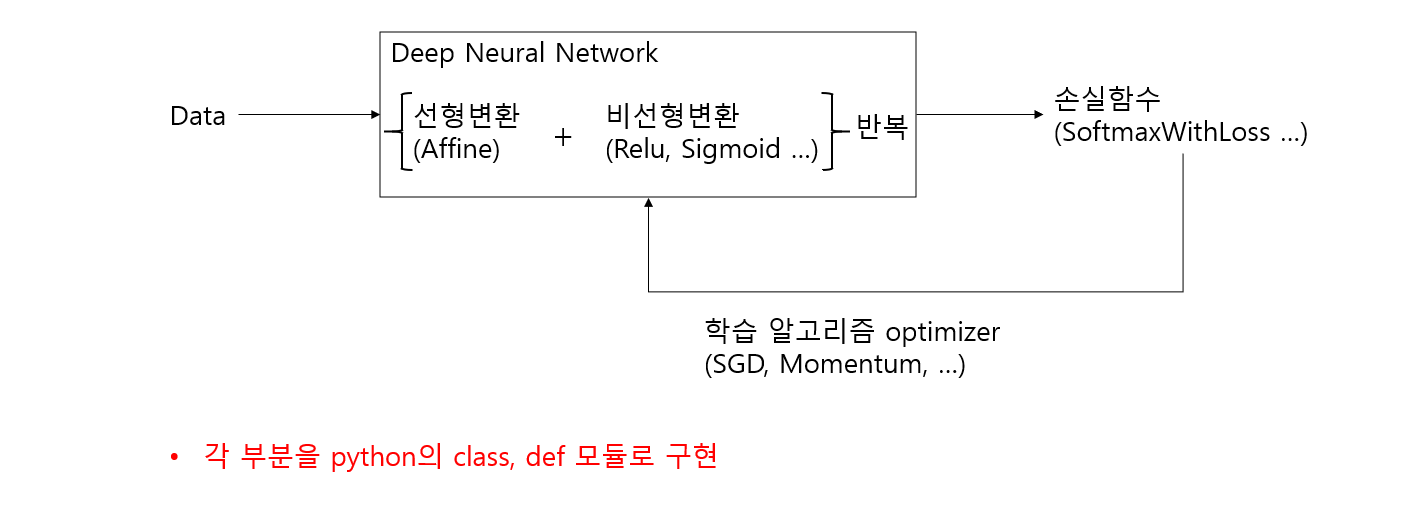

- 밑바닥부터 시작하는 딥러닝에서는 다음과 같은 class, def 모듈을 모아놓은 파일이 있음.
- 이를 사용하여 DNN을 구현해볼 것임

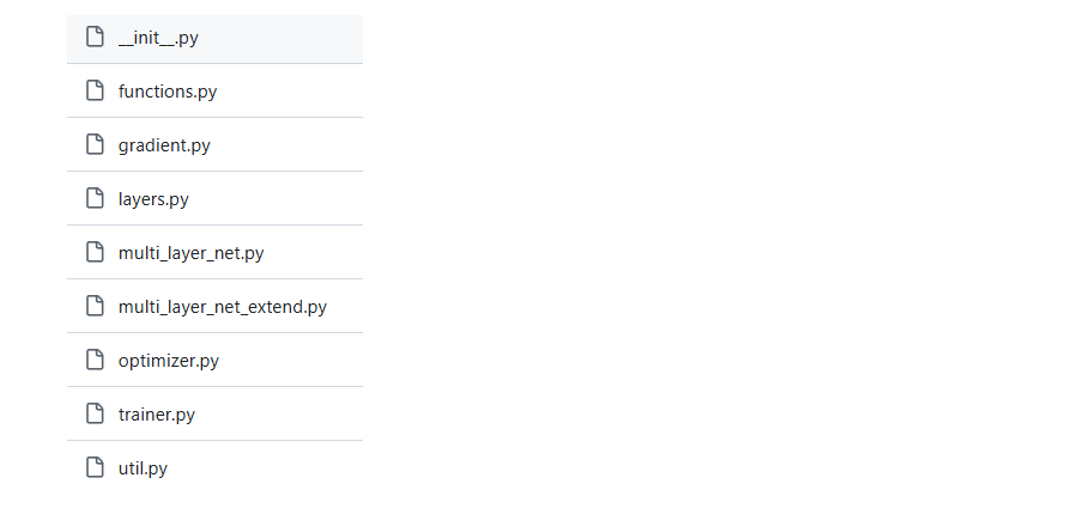

# 
- jupyter notebook 을 사용하여 다른 폴더에 py 파일들을 import 하는 과정

In [1]:
import sys, os

# 1) 현재 노트북(Project/)의 상위 폴더(2025 비교과특강/) 절대경로
base_dir = os.path.abspath('..')

# 2) 중복 추가 방지 후 sys.path에 삽입
if base_dir not in sys.path:
    sys.path.append(base_dir)

# (옵션) 변경된 모듈 자동 반영
%load_ext autoreload
%autoreload 2

In [2]:
# 함수·레이어·최적화 기법 등 필요한 모듈을 한 번에 가져오기
from common.functions               import *
from common.gradient                import *
from common.layers                  import *
from common.multi_layer_net         import *
from common.multi_layer_net_extend  import *
from common.optimizer               import *
from common.trainer                 import *
from common.util                    import *

# 문제 1
## MNIST 데이터 Neural Network로 학습하기
1. [784 ,100 ,50 ,10 ] 구조를 가지는 신경망을 설계하여 학습
2. loss 는 Cross entropy 사용 (Softmax 모듈 사용)

# 
### - MNIST 데이터 로드

In [6]:
import tensorflow as tf

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


# 
#### 1-1번 문제 :
#### Train data와 Test data의 픽셀값을 0에서 1 사이로 정규화하세요.

# 
#### 1-2번 문제 :
#### Train data와 Test data의 shape을 784차원으로 flatten 하세요.

# 
#### 1-3번 문제 :
#### 다음 one-hot 인코딩 함수를 사용하여 Train, Test 의 label을 원핫 인코딩으로 변환하세요.

In [8]:
def one_hot_encode(labels, num_classes=10):
    """
    One-hot encodes a NumPy array of labels.

    Args:
    labels: A 1D NumPy array of labels.
    num_classes: The number of unique classes.

    Returns:
    A 2D NumPy array where each row is a one-hot vector representing a label.
    """

    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

# 
### - MNIST를 풀기위한 신경망 설계
#### 1-4번 문제 : 아래 조건을 만족하는 MultiLayerNet 신경망을 설계하세요.
1. [784 ,100 ,50 ,10 ] 구조를 가지는 신경망을 설계하여 학습 (활성함수는 Sigmoid 사용)
2. loss 는 Cross entropy 사용 (Softmax 모듈 사용)

# 
#### Mini batch 함수
- MNIST 데이터셋은 6만개 학습데이터를 가지므로 한 번에 올려서 학습하는 것이 어려움.
- 그러므로 배치 사이즈로 분할하는 미니 배치 학습 방법을 사용함.
- 아래 shuffle_batch 함수는 데이터와 레이블을 쌍으로 받아서 섞은 후 미니배치로 돌려주는 함수임.

#### 1-5번 문제 :
#### shuffle_batch 함수를 사용하여  아래 for문을 출력해봄으로써 미니 배치로 데이터를 주는 경우를 이해해보세요

In [10]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
for X_batch, y_batch in shuffle_batch(X_train, y_train, 200):
    print(np.shape(X_batch))
    print(np.shape(y_batch))

#### 1-6번 문제 :
#### 아래 조건을 만족하는 MNIST 문제를 학습해보세요.

1. 학습률은 0.1
2. 배치 사이즈는 200
3. 5 에폭 학습, 배치 사이즈로 업데이트마다 (Train data 6만개, Test data 1만개의 손실값 저장하여 학습이 끝난 후 배치 사이즈에 따른 손실값 시각화 그래프 출력)
4. 에폭마다 Train data, Test data에 대한 손실값과 정확도 출력
5. 학습이 모두 끝난 후 Train data와 Test data에 대한 손실값과 정확도 출력

# 
#### 1-7번 문제 :
#### 위 결과를 보고 더 높은 Test data의 정확도를 달성하기 위한 방안을 제안하고 실행해보세요.